# Central Hidroeléctrica Yacyretá
## 11B - XGBRegressor, modelo por desplazamiento diario del vector de predictoras, Optimizacion Bayesiana
### Fecha: 01-Febrero-22

In [1]:
# Para que funcione más rápidamente el intellisense
#%config Completer.use_jedi = False

In [2]:
#Cargo numpy y pandas para trabajar con dataframes
import pandas as pd
import numpy as np

# Cargo datetime para funciones de tiempo
from datetime import date, timedelta, datetime

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 6)

In [3]:
# Imports necesarios para que funcione iplot() como método de pandas
%matplotlib inline
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')

In [4]:
# Planto una semilla para repetitibilidad
import random
random.seed(170162)
np.random.seed(170162)

In [5]:
import pprint

In [6]:
from sktime.utils.plotting import plot_series    

### Importo los regresores

In [7]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso, Ridge  

### Carpeta para los archivos '.csv' y gráficos que se generen

#### Nombre del Experimento

In [8]:
experimento = 'TFI 11 - LGBGRegressor, modelo por desplazamiento, optimizacion'

In [9]:
ahora = str(datetime.now()).replace(':', '-').replace(' ', '_')[:16]
path_grabacion = './output/' + experimento + '/'+ ahora + '/'
# Verifico que la carpeta exista y si no, la creo
import os
if not os.path.exists(path_grabacion):
    os.makedirs(path_grabacion)
    print('\nPath/carpeta de gráficos y de archivos creada:', path_grabacion)


Path/carpeta de gráficos y de archivos creada: ./output/TFI 11 - LGBGRegressor, modelo por desplazamiento, optimizacion/2022-06-16_00-29/


### Lectura del Dataset de la central hidroeléctrica Yacyretá

In [10]:
# Especifico el nombre del archivo con el dataset unificado de la CHY y el path
path = './datasets/CHY/output/'
file_name = 'CHY_dataset.csv'

In [11]:
# Leo el dataset creado en el notebook anterior
df = pd.read_csv(path + file_name)

In [12]:
# veo cabeza y cola del df
df

,FECHA,COTA_EMBALSE,COTA_RESTITUCION,SALTO,QAFLR,QVBP,QVBAC,QTURB,SINP,SADI
0,2011-01-01,82.04,60.17,21.87,13936.0,0.0,1045.0,11977.0,5391.00,49384.000
1,2011-01-02,82.06,60.17,21.89,13267.0,0.0,1045.0,11863.0,5631.60,48785.000
2,2011-01-03,82.07,60.12,21.95,12670.0,0.0,1045.0,11439.0,6871.60,46573.000
3,2011-01-04,82.08,60.12,21.96,12909.0,0.0,1045.0,11505.0,7460.80,46046.000
4,2011-01-05,82.13,60.08,22.05,13787.0,0.0,1047.0,11455.0,6555.00,46721.000
...,...,...,...,...,...,...,...,...,...,...
3828,2021-06-26,82.78,58.94,23.84,6545.0,0.0,1017.0,5157.0,4388.60,21594.112
3829,2021-06-27,82.78,58.94,23.84,6337.0,0.0,1017.0,5135.0,4188.42,21658.536
3830,2021-06-28,82.79,58.93,23.86,6138.0,0.0,1017.0,5121.0,5165.92,20606.040
3831,2021-06-29,82.79,58.93,23.86,6133.0,0.0,1017.0,5116.0,5427.90,20416.960


In [13]:
# Convierto la columna FECHA de object a datetime64
df['FECHA'] = pd.to_datetime(df['FECHA'])

In [14]:
# Hago que la columna FECHA sea el índice
df.set_index('FECHA', inplace=True)

In [15]:
# Si fuera necesario imputar NAN
df = df.asfreq('D', method='ffill')

### Cargo las métricas de evaluación de desempeño

In [16]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError, MeanAbsoluteScaledError

mae = MeanAbsoluteError()
mse = MeanSquaredError()
rmse = MeanSquaredError(square_root=True)
mase = MeanAbsoluteScaledError()

##### Genero lags (hasta 99)

In [17]:
lags = 40
for i in range(1, lags+1):
    df['SALTO-' + str(i).zfill(2)] = df['SALTO'].shift(periods=i)
        
# Borro los registros que quedaron con un NAN al desplazarse
df.dropna(how='any', inplace=True)

### Me quedo con las features (SALTO-) como features, X

In [18]:
# Me quedo con las columnas que comienzan con 'SALTO-'
features = [col for col in df.columns if col[:6] == 'SALTO-']
X = df[features]

### Tomo la columna SALTO como target, y

In [19]:
y = df['SALTO']

#### Conjunto de horizontes de pronóstico

In [20]:
# # horizontes de predicción a explorar
# fh_s = [14]
# #fh_s = [56, 28, 14, 7]

#### Conjunto con los números de lags a utilizar

In [21]:
# #lags_s = [10, 20, 40, 80, 160]
# lags_s = [160]

#### Conjunto de regresores a utilizar

In [22]:
# # Lista con los regresores
# regresores = [ 
# #     KNeighborsRegressor()
# #     ,Lasso()
#     LGBMRegressor(objective='regression', linear_tree=True)
# #     ,LinearRegression()
# #     ,MLPRegressor(max_iter=600, random_state=170162)
# #     ,RandomForestRegressor(criterion='absolute_error', random_state=170162) 
# #     ,Ridge()
# #     ,SVR(gamma='auto', kernel='rbf') 
# #     ,XGBRegressor()
#     ]

### Lazo principal de cálculo

In [23]:
# # Lista para las metricas
# metricas = []

# # Dataframe para los pronósticos
# y_preds = pd.DataFrame()

# # Lazo de cálculo

# # Lazo de los horizontes de predicción
# for fh in fh_s:
    
#     # Extraigo las últimas fh filas del dataframe X
#     y_train = y.iloc[:-fh]

#     # Conjunto de target de testeo 
#     y_test = y.iloc[-fh:]
    
#     y_preds[str(fh) + '_' + 'y_test'] = y_test

#     # Lazo de los conjuntos de lags
#     for lags in lags_s:

#         # Selecciono lag features para X_train
#         X_train = X.iloc[:-fh, 0:lags]

#         # Lazo de los regresores
#         for regresor in regresores:

#             # Ajusto el modelo
#             regresor.fit(X_train, y_train)

#             # Tomo la última fila
#             X_pred = X_train.iloc[-1:,]

#             # Creo el vector, tomando Copio el último valor de y_test
#             y_pred = y_train.iloc[-1:]

#             for i in range(0, fh):

#                 # Desplazo la serie X_pred hacia la derecha (SALTO-1 -> SALTO-2, SALTO-2 -> SALTO-3, etc.)
#                 X_pred = X_pred.shift(periods=1, axis=1)

#                 # Relleno el elemento de X_test que se hizo NaN por el desplazamiento
#                 X_pred['SALTO-01'] = y_pred.iloc[-1:]

#                 # Incremento el index de X_test
#                 X_pred.index = X_pred.index.shift(periods=1, freq='D')

#                 # Predigo con los valores de X_test, convirtiendo el array resultante a serie
#                 y_pred[X_pred.iloc[-1:,].index[0]] = regresor.predict(X_pred)[0]   

#             # Quito el primer valor que introduje para la creación de y_pred (y_train.iloc[-1:])
#             y_pred = y_pred.iloc[1:]

#             # Agrego la predicción al df de predicciones
#             y_preds[str(fh)+'_' + str(lags) + '_' + type(regresor).__name__] = y_pred

#             # Calculo metricas
#             MAE = mae(y_test, y_pred) 
#             MSE = mse(y_test, y_pred)
#             RMSE = rmse(y_true=y_test, y_pred=y_pred) 
#             MASE = mase(y_true=y_test, y_pred=y_pred, y_train=y_train)

#             metricas.append({'fh': fh
#                              ,'lags':lags
#                              ,'regresor': type(regresor).__name__
#                              ,'MAE': MAE
#                              ,'MSE': MSE
#                              ,'RMSE': RMSE
#                              ,'MASE': MASE
#                             })

#             # Ploteo los resultados del regresor/lags
#             titulo = 'Algoritmo: ' + type(regresor).__name__  + ',  features: ' + str(lags) + ',  fh:'+ str(fh) + ', MAE: ' + f'{MAE:0.4f}' + ', RMSE: ' + f'{RMSE:0.4f}'
#             fig, ax = plot_series(y_train[-fh:], y_test, y_pred, labels=["SALTO_train", "SALTO_test", "SALTO_pred"], 
#                                   x_label='Fecha', y_label='metros')
#             plt.figure(figsize=(16, 4))
#             ax.set_title(titulo)
#             ax.tick_params(axis='x', labelrotation = 0)
#             plt.show()

# #         # Ploteo las predicciones de todos los regresores
# #         y_preds.iplot(kind='line'
# #                   ,title='Pronósticos a '+ str(fh) + 'días y con ' + str(lags) + ' variables' 
# #                   ,yTitle='metros'
# #                   ,xTitle='Fecha'
# #                   ,dimensions=(950, 700)
# #                   ,theme='pearl'
# #                   )


### Pronosticador por desplazamiento

In [24]:
def Pronosticador(regresor=LGBMRegressor(objective='regression', linear_tree=True) \
                      ,parametros = {} \
                      ,X=pd.DataFrame() \
                      ,y=pd.Series(dtype='float64') \
                      ,fh=int(0) \
                      ,lags=int(0) \
                      ,plot=False
                     ):
    
    # Selecciono las primeras [0:-fh] filas y [0:lags] columnas del dataframe 'X'como conjunto de training 
    X_train = X.iloc[:-fh, 0:lags]
    
    # Selecciono las primeras '0:-fh' filas de la serie 'y' como conjunto de training
    y_train = y.iloc[:-fh]

    # Selecciono las últimas 'fh' filas de la serie 'y' como conjunto de testeo 
    y_test = y.iloc[-fh:]
    
    # Cargo los parámetros
    if parametros:
        regresor.set_params(**parametros)
    
    # Ajusto el modelo con los conjuntos de training
    regresor.fit(X_train, y_train)

    # Como X_pred inicial, tomo la última fila de X_train, aunque la voy a desplazar luego
    X_pred = X_train.iloc[-1:,]

    # Como primer elemento de la serie y_pred tomo el último valor de y_train, aunque despues lo quito
    y_pred = y_train.iloc[-1:]

    # Lazo de predicción diario
    for i in range(0, fh):

        # Desplazo la serie X_pred hacia la derecha (SALTO-1 -> SALTO-2, SALTO-2 -> SALTO-3, etc.)
        X_pred = X_pred.shift(periods=1, axis=1)

        # Relleno el elemento de X_test que se hizo NaN por el desplazamiento
        X_pred['SALTO-01'] = y_pred.iloc[-1:]

        # Incremento el index de X_test, para preddecir el día siguiente
        X_pred.index = X_pred.index.shift(periods=1, freq='D')

        # Predigo con los valores de X_pred, convirtiendo el array resultante a serie
        y_pred[X_pred.iloc[-1:,].index[0]] = regresor.predict(X_pred)[0]   

    # Quito el primer valor que introduje para la creación de y_pred (y_train.iloc[-1:])
    y_pred = y_pred.iloc[1:]

    # Calculo metricas
    MAE = mae(y_test, y_pred) 
    MSE = mse(y_test, y_pred)
    RMSE = rmse(y_true=y_test, y_pred=y_pred) 
    MASE = mase(y_true=y_test, y_pred=y_pred, y_train=y_train)
    
    # Ploteo los resultados del regresor/lags
    if plot:
        pd.concat([y.iloc[-2*fh:], y_pred.rename('SALTO_pred')], axis=1) \
            .iplot(mode='lines+markers'
                   ,size=5.0
                   ,title='Modelo por desplazamiento: ' + type(regresor).__name__ \
                           + ', ' + str(lags) + ' lags' \
                           + ', pronóstico a ' + str(fh) + ' dias'
                           + ', MAE: ' + str(round(MAE, 4))
                   ,yTitle='metros'
                   ,xTitle='Fecha'
                   ,dimensions=(950, 350))

    return {'regresor': type(regresor).__name__
            ,'paramteros': regresor.get_params()
#             ,'features': regresor.feature_name_
            ,'feature_importances': regresor.feature_importances_
            ,'lags': lags
            ,'fh': fh
            ,'y_pred': y_pred
            ,'MAE': MAE
            ,'MSE': MSE
            ,'RMSE': RMSE
            ,'MASE': MASE
            }

### Valores del modelo a optimizar

In [25]:
fh = 56
lags = 20
regresor = XGBRegressor()

### Pronóstico sin optimización

In [26]:
optimizacion_dict = Pronosticador(regresor \
              ,parametros={
#      'boosting_type': 'gbdt',
#      'class_weight': None,
#      'colsample_bytree': 1.0,
#      'importance_type': 'split',
#      'learning_rate': 0.1,
#      'linear_tree': True,
#      'max_bin': 505, ##
#      'max_depth': 11, ##
#      'min_child_samples': 20,
#      'min_child_weight': 0.001,
#      'min_split_gain': 0.0,
#      'n_estimators': 100,
#      'n_jobs': -1,
#      'num_leaves': 31,
#      'objective': 'regression',
#      'random_state': 170162,
#      'reg_alpha': 0.0,
#      'reg_lambda': 0.0,
#      'silent': 'warn',
#      'subsample': 1.0,
#      'subsample_for_bin': 200000,
#      'subsample_freq': 0
    }
              ,X = X \
              ,y = y \
              ,fh = fh \
              ,lags = lags \
              ,plot = True
             )

In [27]:
keys = ['fh', 'MAE', 'RMSE']
#[resultado_dict.get(key) for key in keys]    

for key, value in optimizacion_dict.items():
    if key in keys:
        print(key, value)

fh 56
MAE 0.10056804520743137
RMSE 0.17846301499739214


In [28]:
# Veo los parámetros utilizados por default
regresor.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'enable_categorical': False,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [29]:
# Prueba de seteo de parámetros

# regresor.set_params(**{'objective': 'reg:squarederror',
#  'base_score': 0.5,
#  'booster': 'gbtree',
#  'colsample_bylevel': 1,
#  'colsample_bynode': 1,
#  'colsample_bytree': 1,
#  'enable_categorical': False})

### Optimización Bayesiana

#### Grilla de Parámetros 

In [30]:
# Importo las clases de datos necesarios para las grillas de parámetros
from skopt.space import Real, Integer, Categorical

# ****** Estos parámetros dependen del regresor utilizado.
# ****** Si se cambia de regresor, hay que cambiar la grilla de parámetros.

# Parámetros fijos a pasar al modelo
# Parámetros fijos del LGBMRegressor
# parametros_fijos = {
#      'boosting_type': 'gbdt',
#      'class_weight': None,
#      'colsample_bytree': 1.0,
#      'importance_type': 'split',
#      'learning_rate': 0.1,
#      'linear_tree': True,
#      'max_bin': 505, ##
#      'max_depth': 11, ##
#      'min_child_samples': 20,
#      'min_child_weight': 0.001,
#      'min_split_gain': 0.0,
#      'n_estimators': 100,
#      'n_jobs': -1,
#      'num_leaves': 31,
#      'objective': 'regression',
#      'random_state': 170162,
#      'reg_alpha': 0.0,
#      'reg_lambda': 0.0,
#      'silent': 'warn',
#      'subsample': 1.0,
#      'subsample_for_bin': 200000,
#      'subsample_freq': 0
#     }

# Parámetros a optimizar LGBMRegressor
# grilla_parametros = [

# ###  Parameters for the Leaf-wise (Best-first) Tree
# #     Categorical(['gbdt', 'dart', 'goss'], name='boosting_type'), # (['gbdt', 'dart', 'goss', 'rf']
#     Integer(0, 20, 'uniform', name='max_depth'), #7
    
# ###  For Better Accuracy
#     Real(0.099, 0.101, 'uniform', name='learning_rate'), #1
#     Integer(80, 120, 'uniform', name='n_estimators'),   #1
    
# ###  Deal with Over-fitting
#     Integer(25, 37, 'uniform', name='num_leaves'),  #2    
#     Integer(400, 700, 'uniform', name='max_bin'),   #2
#     Integer(10, 30, 'uniform', name='min_child_samples'), #3, min_data_in_leaf'
#     Real(0.8, 1.0, 'uniform', name='subsample'), #5, 'bagging_fraction'
#     Integer(0, 100, 'uniform', name='subsample_freq'), #6, 'bagging_freq'
#     Real(0.0, 0.02, 'uniform', name='path_smooth'), #10
#     Categorical([False, True], name='extra_trees'),
#     Real(0.0, 10.0, 'uniform', name='reg_alpha'), # 'lambda_l1'
#     Real(0.0, 10.0, 'uniform', name='reg_lambda'), # 'lambda_l2'
#     Real(0.0, 100.0, 'uniform', name='min_split_gain'), #8, 'min_gain_to_split'

# ###  For Faster Speed
#     Real(0.7, 1.0, 'uniform', name='colsample_bytree'), #4, 'feature_fraction'
#     Real(0.0005, 0.0015, 'uniform', name='min_child_weight'), #9 'min_sum_hessian_in_leaf'
    
#     ]

# -----------------------------------------------------------------------------------------------------

# Parámetros fijos del XGBRegressor
parametros_fijos = {
    }

# Parametros a optimizar del XGBRegressor
# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension ('log-uniform' for the learning rate)

grilla_parametros = [
  Integer(1, 12, prior='uniform', transform='identity', name='max_depth'),
  Real(10**-1, 10**0, prior='uniform', transform='identity', name='learning_rate'),
  Integer(40, 400, prior='uniform', transform='identity', name='n_estimators'),
  Real(0.0, 10**0, prior='uniform', transform='identity', name='colsample_bytree'),
#   Integer(0, 10, prior='uniform', transform='identity', name='alpha'),
#   Integer(0, 10, prior='uniform', transform='identity', name='lambda'),
#   Integer(0, 100, prior='uniform', transform='identity', name='gamma')
    ]

#### Función objetivo a minimizar

In [31]:
# # this decorator allows your objective function to receive the hyper-parameters as
# # keyword arguments. This is particularly convenient when you want to set
# # scikit-learn estimator parameters
# @use_named_args(grilla_parametros)
# def funcion_objetivo(**params):
    
#     # imprimo los parametros en evaluación
#     print(params)

#     score = regresionLGBM(ds, min_ErrorMedio_features, fh, False, False, False, {**parametros_fijos, **params})['MAE']
    
#     # Retorno la media de la métrica durante las cinco evaluaciones del CV
#     return score

from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score

# this decorator allows your objective function to receive the hyper-parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(grilla_parametros)
def funcion_objetivo(**params):
    
    # imprimo los parametros en evaluación
#     print(params)
 
    score = Pronosticador(regresor \
                  ,parametros={**parametros_fijos, **params}
                  ,X = X \
                  ,y = y \
                  ,fh = fh \
                  ,lags = lags \
                  , plot = False        
                 )['MAE']

#     # Defino el regresor con los parámetros que recibe de la función minimizadora
#     regresor = LGBMRegressor().set_params(**{**parametros_fijos, **params})
        
#     # como score utilizo el promedio de los scores de 5 ciclos de cross validation
#     score = np.mean(cross_val_score(
#                                     estimator=regresor, 
#                                     # Entreno sobre todo el dataset
#                                     X=X_train, 
#                                     y=y_train, 
#                                     # Hago crosvalidation en 10 segmentos
#                                     cv=5, 
#                                     # Uso todos los procesadores disponibles
#                                     n_jobs=-1,
#                                     # Le digo al regresor que utilice esta métrica al momento de cortar
#                                     scoring="neg_mean_absolute_error"
#                                     )
#                      )
    
    # Retorno la media de la métrica durante las cinco evaluaciones del CV
    return score

#### Función de Callback

In [32]:
# Funcion que interrumpe la optimización si la mejora después de N_ITER iteraciones no es mejor que MEJORA
def funcion_callback(res_gp):
    print('****Función de Callback: Score actual ===>>>', res_gp.fun)
    return None

#### Función optimizadora

In [33]:
from skopt import gp_minimize

######### Número de iteraciones de optimización
ITERACIONES = 100

res_gp = gp_minimize(func=funcion_objetivo, 
                     dimensions=grilla_parametros, 
                     n_calls=ITERACIONES,
                     callback=funcion_callback, 
                     random_state=170162,
#                      initial_point_generator = 'lhs', #[random, sobol, halton, hammersly, lhs]
#                      acq_func = 'gp_hedge', #[gp_hedge, LCB, EI, PI, EIps, PIps]
#                      acq_optimizer = 'auto', #[lbfgs, sampling, auto]
#                      n_points=15000, 
                     verbose=True,
                     n_jobs=-1
                     )

Iteration No: 1 started. Evaluating function at random point.
****Función de Callback: Score actual ===>>> 0.09643393107822888
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.8954
Function value obtained: 0.0964
Current minimum: 0.0964
Iteration No: 2 started. Evaluating function at random point.
****Función de Callback: Score actual ===>>> 0.09643393107822888
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.8599
Function value obtained: 0.3828
Current minimum: 0.0964
Iteration No: 3 started. Evaluating function at random point.
****Función de Callback: Score actual ===>>> 0.09643393107822888
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4683
Function value obtained: 0.3087
Current minimum: 0.0964
Iteration No: 4 started. Evaluating function at random point.
****Función de Callback: Score actual ===>>> 0.09643393107822888
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.7970
Function value obtained:

****Función de Callback: Score actual ===>>> 0.08713899476187523
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 1.0471
Function value obtained: 0.1254
Current minimum: 0.0871
Iteration No: 33 started. Searching for the next optimal point.
****Función de Callback: Score actual ===>>> 0.08713899476187523
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.0935
Function value obtained: 0.4060
Current minimum: 0.0871
Iteration No: 34 started. Searching for the next optimal point.
****Función de Callback: Score actual ===>>> 0.08713899476187523
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 1.3435
Function value obtained: 0.0959
Current minimum: 0.0871
Iteration No: 35 started. Searching for the next optimal point.
****Función de Callback: Score actual ===>>> 0.08713899476187523
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 0.9583
Function value obtained: 0.2072


****Función de Callback: Score actual ===>>> 0.08691367285592154
Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 1.4085
Function value obtained: 0.0968
Current minimum: 0.0869
Iteration No: 64 started. Searching for the next optimal point.
****Función de Callback: Score actual ===>>> 0.08691367285592154
Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 1.3467
Function value obtained: 0.1046
Current minimum: 0.0869
Iteration No: 65 started. Searching for the next optimal point.
****Función de Callback: Score actual ===>>> 0.08691367285592154
Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 1.4872
Function value obtained: 0.1045
Current minimum: 0.0869
Iteration No: 66 started. Searching for the next optimal point.
****Función de Callback: Score actual ===>>> 0.08691367285592154
Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 1.6284
Function value obtained: 0.0982


****Función de Callback: Score actual ===>>> 0.08582822118486653
Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 1.8625
Function value obtained: 0.0983
Current minimum: 0.0858
Iteration No: 95 started. Searching for the next optimal point.
****Función de Callback: Score actual ===>>> 0.08582822118486653
Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 1.8505
Function value obtained: 0.0930
Current minimum: 0.0858
Iteration No: 96 started. Searching for the next optimal point.
****Función de Callback: Score actual ===>>> 0.08582822118486653
Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 1.5949
Function value obtained: 0.3510
Current minimum: 0.0858
Iteration No: 97 started. Searching for the next optimal point.
****Función de Callback: Score actual ===>>> 0.08582822118486653
Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 1.6278
Function value obtained: 0.4493


#### Progreso de la optimización 

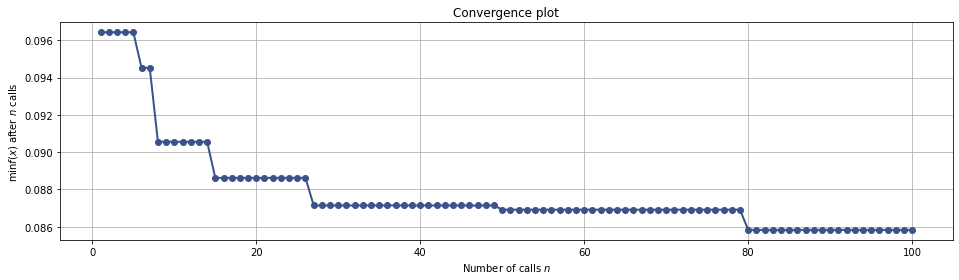

In [34]:
# Grafico el progreso de la minimización
from skopt.plots import plot_convergence

plt.rcParams['figure.figsize'] = (16, 4)
ax = plot_convergence(res_gp)
#ax.set_title(regresor.__class__.__name__ + ' Optimización Bayesiana')
fig = ax.get_figure()
#fig.savefig(path_grabacion + nombre_modelo + ' Optimización Bayesiana' + '.jpg')

#### Parámetros optimizados

In [35]:
# Los mejores parámetros encontrados en la optimización
best_params={**parametros_fijos, **dict(list(zip(res_gp.space.dimension_names, res_gp.x)))}
print('\nMejores parámetros:', best_params)


Mejores parámetros: {'max_depth': 10, 'learning_rate': 0.1, 'n_estimators': 87, 'colsample_bytree': 0.8723608348164507}


#### Regresiono con los nuevos parámetros

In [36]:
optimizacion_dict = Pronosticador(regresor \
                  ,parametros=best_params \
                  ,X=X \
                  ,y=y \
                  ,fh=fh \
                  ,lags=lags \
                  ,plot = True
                 )

In [37]:
keys = ['fh', 'MAE', 'RMSE']
#[resultado_dict.get(key) for key in keys]    

for key, value in optimizacion_dict.items():
    if key in keys:
        print(key, value)

fh 56
MAE 0.08582822118486653
RMSE 0.1684938299011419
